In [13]:
import os 
os.environ['PYTHONHASHSEED'] = '42'
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from torch.utils.data import random_split, DataLoader, TensorDataset
from scipy import stats
from scipy.linalg import orthogonal_procrustes
from sklearn.decomposition import PCA
import requests, zipfile, io
from zipfile import ZipFile
from collections import Counter
import os
import random

In [14]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

In [15]:
import yfinance as yf
import time
import pandas as pd
import numpy as np

class EnhancedStockDataFramework:
    def __init__(self, start_date="2015-01-01", end_date="2024-12-31"):
        self.start_date = start_date
        self.end_date = end_date
        self.raw_data = None
        self.processed_data = None
        self.failed_downloads = []
        self.successful_tickers = []
        
    def get_stock_universe(self):
        tickers = [
            # tech
            'AAPL', 'MSFT', 'NVDA',
            # finance
            'JPM', 'GS', 'V',
            # health and pharma 
            'JNJ', 'PFE', 'MRK',
            # consumer discretionary 
            'AMZN', 'TSLA', 'HD',
            # consumer staples
            'PG', 'KO', 'PEP',
            # industrial and manufacturing
            'BA', 'CAT', 'GE',
            # energy and utilities
            'XOM', 'CVX', 'NEE',
            # materials and basic industries 
            'LIN', 'SHW', 'FCX',
            # real estate and REITs
            'AMT', 'SPG', 'PLD',
            # communication services
            'GOOGL', 'META', 'DIS',
            # emerging growth and others
            'SHOP', 'PLTR', 'SNOW'
        ]
        return tickers

    
    def download_data(self, tickers, max_retries=3, batch_size=10, pause=3):
        print(f"Downloading data for {len(tickers)} stocks...")
        print(f"Date range: {self.start_date} to {self.end_date}")

        all_data = {}
        failed_downloads = []

        for i in range(0, len(tickers), batch_size):
            batch = tickers[i:i+batch_size]
            success = False

            for attempt in range(max_retries):
                try:
                    df = yf.download(
                        tickers=batch,
                        start=self.start_date,
                        end=self.end_date,
                        group_by='ticker',
                        auto_adjust=False,
                        threads=True,
                        progress=False
                    )

                    if df.empty:
                        raise ValueError("Empty DataFrame returned")

                    for t in batch:
                        try:
                            close = df[t]['Close']
                            if not close.empty and len(close) > 252:
                                all_data[t] = close
                            else:
                                print(f"Insufficient data for {t}")
                                failed_downloads.append(t)
                        except Exception as e:
                            print(f"Ticker failed in batch: {t} — {e}")
                            failed_downloads.append(t)

                    success = True
                    break

                except Exception as e:
                    print(f"Attempt {attempt + 1} failed for batch {i//batch_size+1}: {e}")
                    time.sleep(pause)

            if not success:
                print(f"Batch failed: {batch}")
                failed_downloads.extend(batch)

            print(f"Completed batch {i//batch_size + 1}/{(len(tickers) + batch_size - 1) // batch_size}")
            time.sleep(pause)

        self.raw_data = pd.DataFrame(all_data)
        self.failed_downloads = list(set(failed_downloads))
        self.successful_tickers = list(all_data.keys())

        if not self.raw_data.empty:
            print(f"\n✅ Successfully downloaded {len(all_data)} tickers")
            if self.failed_downloads:
                print(f"❌ Failed: {len(self.failed_downloads)} tickers")
                print(f"Examples: {self.failed_downloads[:10]}")
            return True
        else:
            print("ERROR: No data downloaded.")
            return False

    def clean_data(self, min_trading_days=252, max_zero_days=5):
        if self.raw_data is None or self.raw_data.empty:
            print("ERROR: No raw data available for cleaning")
            return False
        
        print(f"Initial data shape: {self.raw_data.shape}")
        
        self.raw_data = self.raw_data.dropna(thresh=min_trading_days, axis=1)
        print(f"After removing stocks with insufficient data: {self.raw_data.shape}")
        
        zero_counts = (self.raw_data <= 0).sum()
        valid_stocks = zero_counts[zero_counts <= max_zero_days].index
        self.raw_data = self.raw_data[valid_stocks]
        print(f"After removing stocks with excessive zero prices: {self.raw_data.shape}")
        
        self.raw_data = self.raw_data.fillna(method='ffill', limit=5)
        self.raw_data = self.raw_data.dropna()

        if self.raw_data.empty:
            print("ERROR: No data remaining after cleaning!")
            return False
        
        print(f"Final cleaned data shape: {self.raw_data.shape}")
        return True

    def calculate_returns(self):
        if self.raw_data is None or self.raw_data.empty:
            print("ERROR: No data available for return calculation")
            return False

        returns = self.raw_data.pct_change().dropna()
        extreme_threshold = 0.5
        returns_clean = returns.clip(lower=-extreme_threshold, upper=extreme_threshold)

        mean_returns = returns_clean.mean()
        volatility = returns_clean.std() * np.sqrt(252)

        self.processed_data = {
            'returns': returns_clean,
            'prices': self.raw_data,
            'mean_daily_return': mean_returns.mean(),
            'mean_daily_volatility': volatility.mean(),
            'num_stocks': len(returns_clean.columns),
            'num_days': len(returns_clean),
            'date_range': f"{returns_clean.index[0].strftime('%Y-%m-%d')} to {returns_clean.index[-1].strftime('%Y-%m-%d')}"
        }

        return True

    def generate_summary(self):
        if self.processed_data is None:
            print("ERROR: No processed data available")
            return

        print("\n" + "="*60)
        print("ENHANCED STOCK DATA FRAMEWORK - SUMMARY")
        print("="*60)
        
        print(f"Successful downloads: {self.processed_data['num_stocks']} stocks")
        print(f"Failed downloads: {len(self.failed_downloads)} stocks")
        print(f"Date range: {self.processed_data['date_range']}")
        print(f"Trading days: {self.processed_data['num_days']}")
        
        print(f"\nData Quality Metrics:")
        print(f"Mean daily return: {self.processed_data['mean_daily_return']:.6f}")
        print(f"Mean daily volatility: {self.processed_data['mean_daily_volatility']:.4f}")
        
        if self.failed_downloads:
            print(f"\n Failed tickers: {self.failed_downloads[:10]}")

    def run_complete_pipeline(self):
        tickers = self.get_stock_universe()
        
        if not self.download_data(tickers):
            print("PIPELINE FAILED: Could not download any data")
            return False
        
        if not self.clean_data():
            print("PIPELINE FAILED: No data remaining after cleaning")
            return False
        
        if not self.calculate_returns():
            print("PIPELINE FAILED: Could not calculate returns")
            return False
        
        self.generate_summary()
        return True

# Example usage
if __name__ == "__main__":
    framework = EnhancedStockDataFramework(
        start_date="2015-01-01",
        end_date="2024-12-31"
    )
    
    success = framework.run_complete_pipeline()
    
    if success:
        print("Pipeline completed successfully!")
        print(f"Access your data via: framework.processed_data")
        
        returns = framework.processed_data['returns']
        prices = framework.processed_data['prices']
        
        print(f"\nReturns shape: {returns.shape}")
        print(f"Prices shape: {prices.shape}")
    else:
        print("Pipeline failed!")


Date range: 2015-01-01 to 2024-12-31



10 Failed downloads:
['V', 'AMZN', 'PFE', 'MRK', 'GS', 'MSFT', 'AAPL', 'NVDA', 'JNJ', 'JPM']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Attempt 1 failed for batch 1: Empty DataFrame returned



10 Failed downloads:
['JPM', 'NVDA', 'V', 'AAPL', 'JNJ', 'PFE', 'MSFT', 'AMZN', 'MRK', 'GS']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Attempt 2 failed for batch 1: Empty DataFrame returned



10 Failed downloads:
['V', 'GS', 'MSFT', 'AAPL', 'MRK', 'JPM', 'PFE', 'NVDA', 'JNJ', 'AMZN']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Attempt 3 failed for batch 1: Empty DataFrame returned
Batch failed: ['AAPL', 'MSFT', 'NVDA', 'JPM', 'GS', 'V', 'JNJ', 'PFE', 'MRK', 'AMZN']
Completed batch 1/4


KeyboardInterrupt: 

ValueError: max() iterable argument is empty

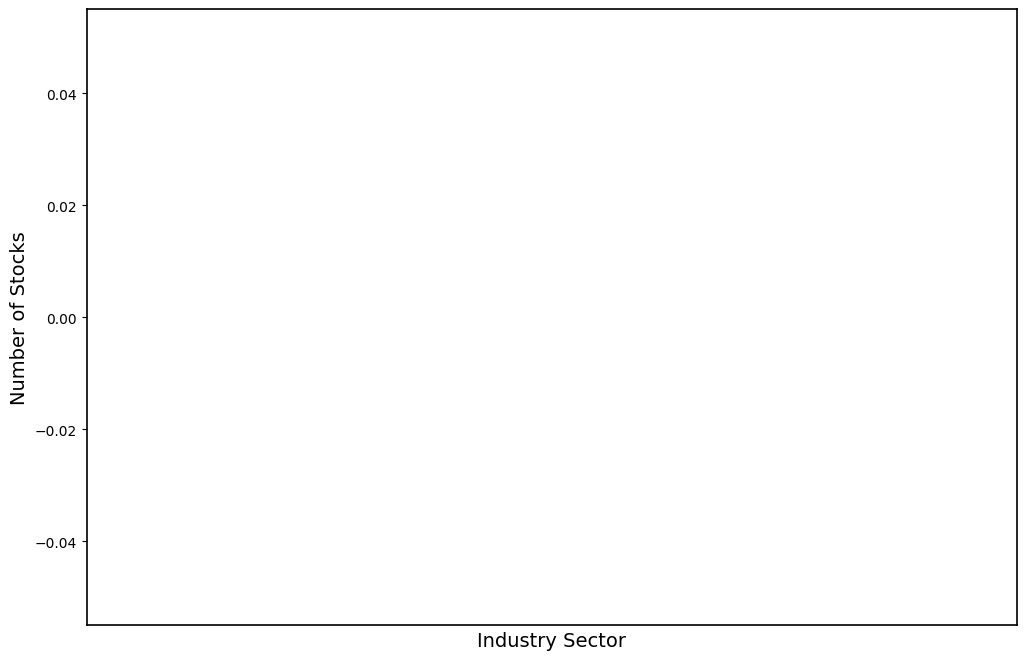

In [ ]:
from collections import Counter

# Set publication-quality plot parameters
plt.rcParams.update({
    'font.size': 12,
    'axes.linewidth': 1.2,
    'axes.labelsize': 12,
    'axes.titlesize': 13,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 14,
    'lines.linewidth': 1.5,
    'axes.grid': False,
    'axes.axisbelow': True,
    'figure.facecolor': 'white',
    'axes.facecolor': 'white'
})

# Function to get market cap category for a ticker
def get_market_cap_category(ticker):
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        market_cap = info.get('marketCap', None)
        if market_cap is None:
            return 'Unknown'
        elif market_cap >= 10e9:
            return 'Large Cap (≥ $10B)'
        elif 2e9 <= market_cap < 10e9:
            return 'Mid Cap ($2B–$10B)'
        elif market_cap < 2e9:
            return 'Small Cap (< $2B)'
        else:
            return 'Unknown'
    except Exception as e:
        return 'Unknown'

# Map sectors (same as before)
sector_map = {
    **dict.fromkeys(['AAPL', 'MSFT', 'NVDA'], 'Tech Giants'),
    **dict.fromkeys(['JPM', 'GS', 'V'], 'Financial Services'),
    **dict.fromkeys(['JNJ', 'PFE', 'MRK'], 'Healthcare & Pharma'),
    **dict.fromkeys(['AMZN', 'TSLA', 'HD'], 'Consumer Discretionary'),
    **dict.fromkeys(['PG', 'KO', 'PEP'], 'Consumer Staples'),
    **dict.fromkeys(['BA', 'CAT', 'GE'], 'Industrial & Manufacturing'),
    **dict.fromkeys(['XOM', 'CVX', 'NEE'], 'Energy & Utilities'),
    **dict.fromkeys(['LIN', 'SHW', 'FCX'], 'Materials & Basic Industries'),
    **dict.fromkeys(['AMT', 'SPG', 'PLD'], 'Real Estate & REITs'),
    **dict.fromkeys(['GOOGL', 'META', 'DIS'], 'Communication Services'),
    **dict.fromkeys(['SHOP', 'PLTR', 'SNOW'], 'Emerging Growth & Others')
}


# Get market caps and sectors for successfully downloaded tickers
sectors = []
for ticker in framework.successful_tickers:
    sectors.append(sector_map.get(ticker, 'Unknown'))

# Count distribution
sector_counts = Counter(sectors)

# Create publication-quality figure
fig, ax = plt.subplots(figsize=(12, 8))

# Sort sectors by count for better visualization
sorted_sectors = sorted(sector_counts.items(), key=lambda x: x[1], reverse=True)
sector_names = [item[0] for item in sorted_sectors]
counts = [item[1] for item in sorted_sectors]

# Create bars with professional styling
bars = ax.bar(range(len(sector_names)), counts, 
              color='#D3869B', alpha=0.8, linewidth=0.5)

# Customize the plot
ax.set_xlabel('Industry Sector', fontsize=14, fontweight='normal')
ax.set_ylabel('Number of Stocks', fontsize=14, fontweight='normal')

# Set x-axis labels
ax.set_xticks(range(len(sector_names)))
ax.set_xticklabels(sector_names, rotation=45, ha='right', fontsize=10)

# Add value labels on top of bars
for i, (bar, count) in enumerate(zip(bars, counts)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{count}', ha='center', va='bottom', fontsize=10, fontweight='normal')

# Customize grid
#ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, axis='y')
ax.set_axisbelow(True)

# Set y-axis to start at 0 and add some padding at the top
ax.set_ylim(0, max(counts) * 1.1)

# Ensure integer ticks on y-axis
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save high-quality versions
plt.savefig('figure_sector_distribution.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')

plt.show()

# Reset matplotlib parameters
plt.rcdefaults()


In [ ]:
# gets the fama french factors from the site for the date range 

def get_daily_fama_french_factors(start_date='2021-11-11', end_date='2024-12-31'):
    """
    Downloads and processes the Fama-French 3-factor daily data from Ken French's website.
    """
    url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_daily_CSV.zip"
    r = requests.get(url)
    z = ZipFile(io.BytesIO(r.content))
    
    # Correct filename from ZIP
    with z.open("F-F_Research_Data_Factors_daily.csv") as f:
        df_raw = pd.read_csv(f, skiprows=3)

    # Drop footer rows that contain non-date strings
    df_raw = df_raw[df_raw.iloc[:, 0].str.match(r'^\d{6,8}$')].copy()

    # Rename columns
    df_raw.columns = ['Date', 'Mkt-RF', 'SMB', 'HML', 'RF']
    df_raw['Date'] = pd.to_datetime(df_raw['Date'], format='%Y%m%d')
    df_raw.set_index('Date', inplace=True)

    # Convert percent to decimal
    df_raw = df_raw.astype(float) / 100.0

    # Filter by date range
    mask = (df_raw.index >= pd.to_datetime(start_date)) & (df_raw.index <= pd.to_datetime(end_date))
    return df_raw.loc[mask]

# Example usage
ff_factors = get_daily_fama_french_factors('2021-11-11', '2024-12-31')

In [ ]:
# now its time put iin all of the frameworks for autoencoders. 
def compute_optimal_A_b_mu(X_np, r):
    mu = np.mean(X_np, axis=0)
    cov = (X_np - mu).T @ (X_np - mu)
    U, S, _ = np.linalg.svd(cov)
    Ur = U[:, :r]  # shape (d, r)
    
    A = Ur.T  # encoder projects from d->r: (r, d)
    b = np.zeros(r)  # no bias needed in latent space
    return A, b, mu


# python packaged affine autoencoder

class ClassicAffineAutoencoder(nn.Module):
    def __init__(self, input_dim, bottleneck_dim):
        super().__init__()
        self.encoder = nn.Linear(input_dim, bottleneck_dim, bias=True)
        self.decoder = nn.Linear(bottleneck_dim, input_dim, bias=True)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat
    

class OptimalAffineAutoencoder(nn.Module):
    def __init__(self, input_dim, r, A, b, mu):
        super().__init__()
        self.A = torch.tensor(A, dtype=torch.float32)
        self.b = torch.tensor(b, dtype=torch.float32)
        self.mu = torch.tensor(mu, dtype=torch.float32)

    def encoder(self, x):
        # Return centered projected latent space: Ur^T(x - mu)
        x_centered = x - self.mu  # center by mean
        UrT = self.A.T  # A = Ur Ur^T ⇒ A.T = Ur^T Ur ⇒ encoder ~ Ur^T
        return x_centered @ UrT  # [batch_size, d] x [d, r] → [batch_size, r]
    
    def decoder(self, z):
        # Reconstruct from latent space: Ur * z + mu
        return z @ self.A + self.mu  # [batch_size, r] x [r, d] → [batch_size, d]

    def forward(self, x):
        # Complete encode-decode cycle
        z = self.encoder(x)
        return self.decoder(z)
# this is a combination modeel that allows for training after instantiation of optimal theoretical weights. 

class OptimalTrainableAffineAutoencoder(nn.Module):
    def __init__(self, input_dim, r, A_init, b_init, mu_init):
        super().__init__()
        self.A = nn.Parameter(torch.tensor(A_init, dtype=torch.float32))  # (r, d)
        self.b = nn.Parameter(torch.tensor(b_init, dtype=torch.float32))  # (r,)
        self.mu = nn.Parameter(torch.tensor(mu_init, dtype=torch.float32))  # (d,)

    def encoder(self, x):
        x_centered = x - self.mu  # (batch, d)
        return x_centered @ self.A.T + self.b  # (batch, r)

    def decoder(self, z):
        return z @ self.A + self.mu  # (batch, d)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

# NONLINEAR AUTOENCODER 
class NonlinearAutoencoder(nn.Module):
    def __init__(self, input_dim, bottleneck_dim, hidden_dim=64):
        super().__init__()
        
        # Encoder: input -> hidden -> hidden -> bottleneck
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, bottleneck_dim)
        )
        
        # Decoder: bottleneck -> hidden -> hidden -> output
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

def train_autoencoder(model, train_loader, val_loader, num_epochs=300, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            recon = model(batch)
            loss = criterion(recon, batch)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * batch.size(0)

        avg_train_loss = total_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                recon = model(batch)
                loss = criterion(recon, batch)
                total_val_loss += loss.item() * batch.size(0)

        avg_val_loss = total_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)
    return model, train_losses, val_losses



# validation function only code for the optimal affine autoencoder
def valOnlyOptimalAffineAutoencoder(model, val_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    model.eval()
    total_loss = 0
    criterion = nn.MSELoss()

    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            recon = model(batch)
            loss = criterion(recon, batch)
            total_loss += loss.item() * batch.size(0)

    avg_loss = total_loss / len(val_loader.dataset)
    return avg_loss 

In [ ]:
# VARIMAX AND EXPLAINED VARIANCE FUNCTION DEFINITIONS 
def varimax_rotation(loadings, gamma=1.0, q=20, tol=1e-6):
    loadings = np.array(loadings)
    n_features, n_factors = loadings.shape
    
    T = np.eye(n_factors)
    
    for iteration in range(q):
        T_old = T.copy()
        
        # Current rotated loadings
        L = loadings @ T
        
        # Varimax criterion - maximize variance of squared loadings
        # Compute gradient of varimax objective
        u = n_features * L**3 - gamma * L @ np.diag(np.sum(L**2, axis=0))
        
        # SVD to find optimal rotation
        A = loadings.T @ u
        U, s, Vt = np.linalg.svd(A)
        T = U @ Vt
        
        # Check convergence
        if np.sum((T - T_old)**2) < tol:
            break
    
    rotated_loadings = loadings @ T
    return rotated_loadings, T

# COMPUTE THE EXPLAINED VARIANCE FOR EACH FACTOR 
def compute_explained_variance(factors, original_data):
    loadings = np.linalg.lstsq(factors, original_data, rcond=None)[0]  # shape: (n_factors, n_features)
    
    # Reconstruct data using each factor individually
    total_var = np.var(original_data, axis=0, ddof=1).sum()
    explained_vars = []
    
    for i in range(factors.shape[1]):
        # Reconstruct using only factor i
        reconstructed = np.outer(factors[:, i], loadings[i, :])
        explained_var = np.var(reconstructed, axis=0, ddof=1).sum()
        explained_vars.append(explained_var)
    
    explained_var_ratio = np.array(explained_vars) / total_var
    cumulative_var = np.cumsum(explained_var_ratio)
    
    return explained_var_ratio, cumulative_var

def analyze_factor_loadings(factors, original_data, method_name=""):
    # Compute factor loadings via regression: loadings = (factors^T * factors)^-1 * factors^T * data
    factors = np.array(factors)
    original_data = np.array(original_data)
    
    # Compute loadings: each column is the loading for one factor
    loadings = np.linalg.lstsq(factors, original_data, rcond=None)[0].T  # shape: (n_features, n_factors)
    
    # Perform varimax rotation on loadings
    rotated_loadings, rotation_matrix = varimax_rotation(loadings)
    
    # Rotate the factors accordingly
    rotated_factors = factors @ rotation_matrix
    
    # Compute explained variance
    explained_var_ratio, cumulative_var = compute_explained_variance(factors, original_data)
    rotated_explained_var_ratio, rotated_cumulative_var = compute_explained_variance(rotated_factors, original_data)
    
    results = {
        'loadings': loadings,
        'rotated_loadings': rotated_loadings,
        'rotation_matrix': rotation_matrix,
        'rotated_factors': rotated_factors,
        'explained_var_ratio': explained_var_ratio,
        'cumulative_var': cumulative_var,
        'rotated_explained_var_ratio': rotated_explained_var_ratio,
        'rotated_cumulative_var': rotated_cumulative_var
    }
    
    if method_name:
        print(f"\n{method_name} Factor Analysis:")
        print(f"  Explained Variance Ratio: {explained_var_ratio}")
        print(f"  Cumulative Variance: {cumulative_var}")
        print(f"  Rotated Explained Variance Ratio: {rotated_explained_var_ratio}")
        print(f"  Rotated Cumulative Variance: {rotated_cumulative_var}")
    
    return results

# Add this to your main pipeline - insert after storing latent representations
def add_factor_analysis_to_pipeline():
    # Get validation data for this run
    val_tensor = X_tensor[val_data.indices]
    X_val_np = val_tensor.numpy()
    
    # Analyze each method
    classic_analysis = analyze_factor_loadings(
        results['classic_factors'][-1], X_val_np, "Classic AE"
    )
    optimal_analysis = analyze_factor_loadings(
        results['optimal_factors'][-1], X_val_np, "Optimal AE"
    )
    trainable_analysis = analyze_factor_loadings(
        results['trainable_factors'][-1], X_val_np, "Trainable AE"
    )
    pca_analysis = analyze_factor_loadings(
        results['pca_factors'][-1], X_val_np, "PCA"
    )
    
    # Store results
    results.setdefault('classic_analysis', []).append(classic_analysis)
    results.setdefault('optimal_analysis', []).append(optimal_analysis)
    results.setdefault('trainable_analysis', []).append(trainable_analysis)
    results.setdefault('pca_analysis', []).append(pca_analysis)



# After all runs complete, analyze average results
def analyze_average_factor_results(results):
    """
    Analyze average factor analysis results across all runs
    """
    methods = ['classic', 'optimal', 'trainable', 'pca']
    
    print("\n" + "="*60)
    print("AVERAGE FACTOR ANALYSIS RESULTS ACROSS ALL RUNS")
    print("="*60)
    
    for method in methods:
        analysis_key = f'{method}_analysis'
        if analysis_key in results:
            analyses = results[analysis_key]
            
            # Average explained variance ratios
            avg_explained_var = np.mean([a['explained_var_ratio'] for a in analyses], axis=0)
            avg_cumulative_var = np.mean([a['cumulative_var'] for a in analyses], axis=0)
            avg_rotated_explained_var = np.mean([a['rotated_explained_var_ratio'] for a in analyses], axis=0)
            avg_rotated_cumulative_var = np.mean([a['rotated_cumulative_var'] for a in analyses], axis=0)
            
            print(f"\n{method.upper()} METHOD:")
            print(f"  Average Explained Variance Ratio: {avg_explained_var}")
            print(f"  Average Cumulative Variance: {avg_cumulative_var}")
            print(f"  Average Rotated Explained Variance Ratio: {avg_rotated_explained_var}")
            print(f"  Average Rotated Cumulative Variance: {avg_rotated_cumulative_var}")
            
            # Show factor interpretability (how much variance is concentrated)
            loading_concentration = np.mean([np.std(np.abs(a['rotated_loadings']), axis=0) for a in analyses], axis=0)
            print(f"  Loading Concentration (higher = more interpretable): {loading_concentration}")





# THIS IS WHERE THE ACTUAL PIPELINE STARTS !!! 
X_np = framework.processed_data['returns']  
X_tensor = torch.from_numpy(X_np.values).float()    

n_samples = X_tensor.shape[0]
train_size = int(0.8 * n_samples)
val_size = n_samples - train_size

g = torch.Generator()
g.manual_seed(seed)



# Slice chronologically
train_data = X_tensor[:train_size]
val_data = X_tensor[train_size:]
val_indices = np.arange(train_size, len(X_np))  
val_dates = X_np.index[val_indices]

# Create DataLoader for training and validation
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
val_loader   = DataLoader(val_data, batch_size=batch_size, shuffle=False)

print(f"Data shape: {X_np.shape}")
print(f"Data type: {type(X_np)}")
print(f"Tensor shape: {X_tensor.shape}")


# Set dimensions
input_dim = X_np.shape[1]
r = 3  # bottleneck dimension

# Compute optimal affine params once
A, b, mu = compute_optimal_A_b_mu(X_np, r)

# Initialize results
results = {
    'classic_mse': [],
    'optimal_mse': [],
    'trainable_mse': [],
    'nonlinear_mse': [],
    'classic_train_loss': [],
    'classic_val_loss': [],
    'trainable_train_loss': [],
    'trainable_val_loss': [],
    'nonlinear_train_loss': [],
    'nonlinear_val_loss': [],
    'classic_train_histories': [],
    'classic_val_histories': [],
    'trainable_train_histories': [],
    'trainable_val_histories': [],
    'nonlinear_train_histories': [],
    'nonlinear_val_histories': [],
    'classic_factors': [],
    'optimal_factors': [],
    'trainable_factors': [],
    'nonlinear_factors': [],
}
    # Init models
model_classic = ClassicAffineAutoencoder(input_dim, r)
model_optimal = OptimalAffineAutoencoder(input_dim, r, A, b, mu)
model_optimal_trainable = OptimalTrainableAffineAutoencoder(input_dim, r, A, b, mu)
model_nonlinear = NonlinearAutoencoder(input_dim, r)

    # Train Classic AE
model_classic, losses_classic_train, losses_classic_val = train_autoencoder(
    model_classic, train_loader, val_loader, num_epochs=100, lr=0.001
)

    # Validate Optimal AE
loss_optimal_val = valOnlyOptimalAffineAutoencoder(model_optimal, val_loader)

    # Train Trainable Optimal AE
model_optimal_trainable, losses_trainable_train, losses_trainable_val = train_autoencoder(
    model_optimal_trainable, train_loader, val_loader, num_epochs=20, lr=0.001
)

    # Train Nonlinear AE
model_nonlinear, losses_nonlinear_train, losses_nonlinear_val = train_autoencoder(
    model_nonlinear, train_loader, val_loader, num_epochs=100, lr=0.001
)

    # PCA baseline

X_train_np = train_data.numpy()
X_val_np = val_data.numpy()

pca = PCA(n_components=r)
pca.fit(X_train_np)

Z_pca_val = pca.transform(X_val_np)  # latent
X_pca_reconstructed = pca.inverse_transform(Z_pca_val)  # reconstruction

mse_pca = np.mean((X_val_np - X_pca_reconstructed) ** 2)
results.setdefault('pca_mse', []).append(mse_pca)
results.setdefault('pca_factors', []).append(Z_pca_val)

    # Save MSE results
results['classic_mse'].append(min(losses_classic_val))
results['optimal_mse'].append(loss_optimal_val)
results['trainable_mse'].append(min(losses_trainable_val))
results['nonlinear_mse'].append(min(losses_nonlinear_val))

    # Save final losses

results['classic_train_loss'].append(losses_classic_train[-1])
results['classic_val_loss'].append(losses_classic_val[-1])
results['trainable_train_loss'].append(losses_trainable_train[-1])
results['trainable_val_loss'].append(losses_trainable_val[-1])
results['nonlinear_train_loss'].append(losses_nonlinear_train[-1])
results['nonlinear_val_loss'].append(losses_nonlinear_val[-1])

    # Save loss histories
results['classic_train_histories'].append(losses_classic_train)
results['classic_val_histories'].append(losses_classic_val)
results['trainable_train_histories'].append(losses_trainable_train)
results['trainable_val_histories'].append(losses_trainable_val)
results['nonlinear_train_histories'].append(losses_nonlinear_train)
results['nonlinear_val_histories'].append(losses_nonlinear_val)
    # Store latent representations (optional, unaligned)
with torch.no_grad():
    X_val_np = val_data.numpy()
        
        # Store latent representations
    classic_factors = model_classic.encoder(val_data).cpu().numpy()
    optimal_factors = model_optimal.encoder(val_data).cpu().numpy()
    trainable_factors = model_optimal_trainable.encoder(val_data).cpu().numpy()
    nonlinear_factors = model_nonlinear.encoder(val_data).cpu().numpy()

    results['classic_factors'].append(classic_factors)
    results['optimal_factors'].append(optimal_factors)
    results['trainable_factors'].append(trainable_factors)
    results['nonlinear_factors'].append(nonlinear_factors)

        # Perform factor analysis with rotation
        # For other runs, compute without printing
    classic_analysis = analyze_factor_loadings(classic_factors, X_val_np, "")
    optimal_analysis = analyze_factor_loadings(optimal_factors, X_val_np, "")
    trainable_analysis = analyze_factor_loadings(trainable_factors, X_val_np, "")
    pca_analysis = analyze_factor_loadings(results['pca_factors'][-1], X_val_np, "")
    nonlinear_analysis = analyze_factor_loadings(nonlinear_factors, X_val_np, "")

        # Store analysis results
    results.setdefault('classic_analysis', []).append(classic_analysis)
    results.setdefault('optimal_analysis', []).append(optimal_analysis)
    results.setdefault('trainable_analysis', []).append(trainable_analysis)
    results.setdefault('pca_analysis', []).append(pca_analysis)
    results.setdefault('nonlinear_analysis', []).append(nonlinear_analysis)

# Remove timezone info to match ff_factors index
val_dates_naive = val_dates.tz_localize(None)

ff_val = ff_factors.loc[val_dates_naive]
ff_factors_latent = ff_val[['Mkt-RF', 'SMB', 'HML']].values

# Drop RF column and keep only Mkt-RF, SMB, HML
ff_factors_latent = ff_factors_latent[:, :3]
print(f"Returns index dtype: {X_np.index.dtype}, tz: {X_np.index.tz}")
print(f"FF factors index dtype: {ff_val.index.dtype}, tz: {ff_val.index.tz}")

# If one has timezone and other doesn’t, convert to timezone naive:
X_dates_naive = X_np.index.tz_localize(None) if X_np.index.tz else X_np.index
ff_dates_naive = ff_factors.index.tz_localize(None) if ff_factors.index.tz else ff_factors.index

common_dates = X_dates_naive.intersection(ff_dates_naive)
print(f"Number of common dates after tz fix: {len(common_dates)}")

# Store and analyze
results.setdefault('ff_factors', []).append(ff_factors_latent)
ff_analysis = analyze_factor_loadings(ff_factors_latent, X_val_np, "Fama-French (GT)")
results.setdefault('ff_analysis', []).append(ff_analysis)
results.setdefault('pca_factors', []).append(Z_pca_val)

# 3. AFTER YOUR MAIN LOOP COMPLETES: Add this analysis
print("FINAL RESULTS SUMMARY")

# Your existing results summary
for key in ['classic_mse', 'optimal_mse', 'trainable_mse', 'pca_mse', 'nonlinear_mse']:
    values = results[key]
    print(f"{key}: mean = {np.mean(values):.8f},  min = {np.min(values):.8f}, max = {np.max(values):.8f}")


# Compare factor stability across runs
def compare_factor_stability(results):
    print("FACTOR STABILITY ANALYSIS")

    methods = ['classic', 'optimal', 'trainable', 'pca', 'ff', 'nonlinear']
    
    for method in methods:
        analysis_key = f'{method}_analysis'
        if analysis_key in results:
            analyses = results[analysis_key]
            
            # Look at consistency of explained variance across runs
            explained_vars = [a['rotated_explained_var_ratio'] for a in analyses]
            mean_explained = np.mean(explained_vars, axis=0)
            std_explained = np.std(explained_vars, axis=0)
            
            print(f"\n{method.upper()} - Rotated Factor Stability:")
            print(f"  Factor 1 (Market?): {mean_explained[0]:.3f}")
            print(f"  Factor 2 (Size?):   {mean_explained[1]:.3f} ")
            print(f"  Factor 3 (Value?):  {mean_explained[2]:.3f} ")
            
            # Check if factors are well-separated
            total_explained = np.sum(mean_explained)
            print(f"  Total Explained Variance: {total_explained:.3f}")
            
            # Factor balance (ideally factors should be somewhat balanced)
            max_factor = np.max(mean_explained)
            min_factor = np.min(mean_explained)
            balance_ratio = min_factor / max_factor
            print(f"  Factor Balance (higher=better): {balance_ratio:.3f}")

# Call the stability analysis
compare_factor_stability(results)


Data shape: (787, 194)
Data type: <class 'pandas.core.frame.DataFrame'>
Tensor shape: torch.Size([787, 194])
Returns index dtype: datetime64[ns, America/New_York], tz: America/New_York
FF factors index dtype: datetime64[ns], tz: None
Number of common dates after tz fix: 787

Fama-French (GT) Factor Analysis:
  Explained Variance Ratio: [0.18158941 0.0213758  0.04943703]
  Cumulative Variance: [0.18158941 0.20296521 0.25240223]
  Rotated Explained Variance Ratio: [0.12571907 0.01839108 0.10343888]
  Rotated Cumulative Variance: [0.12571907 0.14411016 0.24754904]
FINAL RESULTS SUMMARY
classic_mse: mean = 0.00040797,  min = 0.00040797, max = 0.00040797
optimal_mse: mean = 0.00028766,  min = 0.00028766, max = 0.00028766
trainable_mse: mean = 0.00029120,  min = 0.00029120, max = 0.00029120
pca_mse: mean = 0.00029557,  min = 0.00029557, max = 0.00029557
nonlinear_mse: mean = 0.00029912,  min = 0.00029912, max = 0.00029912
FACTOR STABILITY ANALYSIS

CLASSIC - Rotated Factor Stability:
  Facto

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

X_val = val_data.numpy()
r = 3  # number of latent factors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

results = {
    'linear_analysis': [],
    'nonlinear_analysis': [],
    'linear_train_mse': [],
    'linear_val_mse': [],
    'nonlinear_train_mse': [],
    'nonlinear_val_mse': []
}

# Run 100 iterations
for run in range(100):
    seed = 42 + run  # Different seed for each run
    set_seed(seed)
    
    # Print progress every 10 runs
    if (run + 1) % 10 == 0:
        print(f"Completed run {run + 1}/100")
    
    # Init model and train model
    modellinear = ClassicAffineAutoencoder(input_dim, r).to(device)
    modelnonlinear = NonlinearAutoencoder(input_dim, r).to(device)
    
    modellinear, train_losslinear, val_losslinear = train_autoencoder(
        modellinear, train_loader, val_loader, num_epochs=150, lr=0.001)
    modelnonlinear, train_lossnonlinear, val_lossnonlinear = train_autoencoder(
        modelnonlinear, train_loader, val_loader, num_epochs=100, lr=0.001)
    
    # Store final MSE values (assuming losses are MSE)
    results['linear_train_mse'].append(train_losslinear[-1])  # Final training MSE
    results['linear_val_mse'].append(val_losslinear[-1])      # Final validation MSE
    results['nonlinear_train_mse'].append(train_lossnonlinear[-1])  # Final training MSE
    results['nonlinear_val_mse'].append(val_lossnonlinear[-1])      # Final validation MSE
    
    # Get factors
    classic_factors = modellinear.encoder(val_data).detach().cpu().numpy()
    nonlinear_factors = modelnonlinear.encoder(val_data).detach().cpu().numpy()
    
    # Analyze factor loadings (without printing)
    classic_analysis = analyze_factor_loadings(classic_factors, X_val, "")
    nonlinear_analysis = analyze_factor_loadings(nonlinear_factors, X_val, "")
    
    # Store analysis results
    results['linear_analysis'].append(classic_analysis)
    results['nonlinear_analysis'].append(nonlinear_analysis)

# Extract explained variance ratios from each analysis
linear_explained_vars = [analysis['rotated_explained_var_ratio'] for analysis in results['linear_analysis']]
nonlinear_explained_vars = [analysis['rotated_explained_var_ratio'] for analysis in results['nonlinear_analysis']]

# Convert to numpy arrays
linear_explained_vars = np.array(linear_explained_vars)
nonlinear_explained_vars = np.array(nonlinear_explained_vars)

# Convert MSE lists to numpy arrays
linear_train_mse = np.array(results['linear_train_mse'])
linear_val_mse = np.array(results['linear_val_mse'])
nonlinear_train_mse = np.array(results['nonlinear_train_mse'])
nonlinear_val_mse = np.array(results['nonlinear_val_mse'])

# Compute statistics
linear_mean = np.mean(linear_explained_vars, axis=0)
linear_std = np.std(linear_explained_vars, axis=0)
nonlinear_mean = np.mean(nonlinear_explained_vars, axis=0)
nonlinear_std = np.std(nonlinear_explained_vars, axis=0)

# Compute MSE statistics
linear_train_mse_mean = np.mean(linear_train_mse)
linear_train_mse_std = np.std(linear_train_mse)
linear_val_mse_mean = np.mean(linear_val_mse)
linear_val_mse_std = np.std(linear_val_mse)

nonlinear_train_mse_mean = np.mean(nonlinear_train_mse)
nonlinear_train_mse_std = np.std(nonlinear_train_mse)
nonlinear_val_mse_mean = np.mean(nonlinear_val_mse)
nonlinear_val_mse_std = np.std(nonlinear_val_mse)

# Print results following your framework style
print("\n" + "="*60)
print("AVERAGE FACTOR ANALYSIS RESULTS ACROSS ALL RUNS")
print("="*60)

print(f"\nLINEAR METHOD:")
print(f"  Average Explained Variance Ratio: {linear_mean}")
print(f"  Std Explained Variance Ratio: {linear_std}")
print(f"  Training MSE: {linear_train_mse_mean:.8f} ± {linear_train_mse_std:.8f}")
print(f"  Validation MSE: {linear_val_mse_mean:.8f} ± {linear_val_mse_std:.8f}")

print(f"\nNONLINEAR METHOD:")
print(f"  Average Explained Variance Ratio: {nonlinear_mean}")
print(f"  Std Explained Variance Ratio: {nonlinear_std}")
print(f"  Training MSE: {nonlinear_train_mse_mean:.8f} ± {nonlinear_train_mse_std:.8f}")
print(f"  Validation MSE: {nonlinear_val_mse_mean:.8f} ± {nonlinear_val_mse_std:.8f}")

# Factor stability analysis
print("\n" + "="*60)
print("FACTOR STABILITY ANALYSIS")
print("="*60)

methods = [('LINEAR', linear_mean, linear_std), ('NONLINEAR', nonlinear_mean, nonlinear_std)]

for method_name, mean_explained, std_explained in methods:
    print(f"\n{method_name} - Rotated Factor Stability:")
    print(f"  Factor 1: {mean_explained[0]:.4f} ± {std_explained[0]:.4f}")
    print(f"  Factor 2: {mean_explained[1]:.4f} ± {std_explained[1]:.4f}")
    print(f"  Factor 3: {mean_explained[2]:.4f} ± {std_explained[2]:.4f}")
    
    # Check if factors are well-separated
    total_explained = np.sum(mean_explained)
    print(f"  Total Explained Variance: {total_explained:.4f}")

    # Factor balance (ideally factors should be somewhat balanced)
    max_factor = np.max(mean_explained)
    min_factor = np.min(mean_explained)
    balance_ratio = min_factor / max_factor
    balance_std = np.std(balance_ratio)
    print(f"  Factor Balance (higher=better): {balance_ratio:.4f}")
    print(f"  Balance Std: {balance_std:.4f}")

# Additional analysis: Compare cumulative variance
linear_cumulative = [analysis['rotated_cumulative_var'] for analysis in results['linear_analysis']]
nonlinear_cumulative = [analysis['rotated_cumulative_var'] for analysis in results['nonlinear_analysis']]

# Convert to numpy arrays for proper statistics
linear_cumulative = np.array(linear_cumulative)
nonlinear_cumulative = np.array(nonlinear_cumulative)

linear_cumulative_mean = np.mean(linear_cumulative, axis=0)
linear_cumulative_std = np.std(linear_cumulative, axis=0)
nonlinear_cumulative_mean = np.mean(nonlinear_cumulative, axis=0)
nonlinear_cumulative_std = np.std(nonlinear_cumulative, axis=0)

print("\n" + "="*60)
print("CUMULATIVE VARIANCE ANALYSIS")
print("="*60)

print(f"\nLINEAR - Average Cumulative Variance: {linear_cumulative_mean}")
print(f"LINEAR - Std Cumulative Variance: {linear_cumulative_std}")
print(f"NONLINEAR - Average Cumulative Variance: {nonlinear_cumulative_mean}")
print(f"NONLINEAR - Std Cumulative Variance: {nonlinear_cumulative_std}")

# Detailed cumulative variance breakdown
print(f"\nDETAILED CUMULATIVE VARIANCE:")
print(f"LINEAR:")
for i in range(len(linear_cumulative_mean)):
    print(f"  Up to Factor {i+1}: {linear_cumulative_mean[i]:.4f} ± {linear_cumulative_std[i]:.4f}")

print(f"NONLINEAR:")
for i in range(len(nonlinear_cumulative_mean)):
    print(f"  Up to Factor {i+1}: {nonlinear_cumulative_mean[i]:.4f} ± {nonlinear_cumulative_std[i]:.4f}")

# MSE Comparison Section
print("\n" + "="*60)
print("MSE PERFORMANCE COMPARISON")
print("="*60)

print(f"\nTRAINING MSE:")
print(f"  Linear Model:    {linear_train_mse_mean:.8f} ± {linear_train_mse_std:.8f}")
print(f"  Nonlinear Model: {nonlinear_train_mse_mean:.8f} ± {nonlinear_train_mse_std:.8f}")


print(f"\nVALIDATION MSE:")
print(f"  Linear Model:    {linear_val_mse_mean:.8f} ± {linear_val_mse_std:.8f}")
print(f"  Nonlinear Model: {nonlinear_val_mse_mean:.8f} ± {nonlinear_val_mse_std:.8f}")


# Overfitting analysis
print(f"\nOVERFITTING ANALYSIS:")
linear_overfitting = linear_val_mse_mean - linear_train_mse_mean
nonlinear_overfitting = nonlinear_val_mse_mean - nonlinear_train_mse_mean



# Summary comparison
print("\n" + "="*60)
print("SUMMARY COMPARISON")
print("="*60)

print(f"Linear Model    - Total Variance Explained: {np.sum(linear_mean):.4f}")
print(f"Nonlinear Model - Total Variance Explained: {np.sum(nonlinear_mean):.4f}")

print(f"Linear Model    - Most Important Factor: {np.max(linear_mean):.4f}")
print(f"Nonlinear Model - Most Important Factor: {np.max(nonlinear_mean):.4f}")

print(f"Linear Model    - Factor Balance: {np.min(linear_mean)/np.max(linear_mean):.4f}")
print(f"Nonlinear Model - Factor Balance: {np.min(nonlinear_mean)/np.max(nonlinear_mean):.4f}")

print(f"Linear Model    - Validation MSE: {linear_val_mse_mean:.8f}")
print(f"Nonlinear Model - Validation MSE: {nonlinear_val_mse_mean:.8f}")

Completed run 10/100
Completed run 20/100
Completed run 30/100
Completed run 40/100
Completed run 50/100
Completed run 60/100
Completed run 70/100
Completed run 80/100
Completed run 90/100
Completed run 100/100

AVERAGE FACTOR ANALYSIS RESULTS ACROSS ALL RUNS

LINEAR METHOD:
  Average Explained Variance Ratio: [0.04841822 0.05318192 0.05392538]
  Std Explained Variance Ratio: [0.04872584 0.05492875 0.04914283]
  Training MSE: 0.00049337 ± 0.00001052
  Validation MSE: 0.00040017 ± 0.00000419

NONLINEAR METHOD:
  Average Explained Variance Ratio: [0.07546662 0.08004685 0.06692649]
  Std Explained Variance Ratio: [0.06437017 0.06357637 0.05377892]
  Training MSE: 0.00027245 ± 0.00000306
  Validation MSE: 0.00030224 ± 0.00000461

FACTOR STABILITY ANALYSIS

LINEAR - Rotated Factor Stability:
  Factor 1: 0.0484 ± 0.0487
  Factor 2: 0.0532 ± 0.0549
  Factor 3: 0.0539 ± 0.0491
  Total Explained Variance: 0.1555
  Factor Balance (higher=better): 0.8979
  Balance Std: 0.0000

NONLINEAR - Rotated